In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#For a patato plant there can be 3 types of classification:
#1. Healthy
#2. Early Blight(Fungus)
#3. Late Blight(Micro Organism)

In [4]:
#Procedure:
#Data Cleaning and preprocessing(dataset and data augmentation) --> Model Building(CNN) --> server(With services and APIs service) --> Website using ReactJS

 # DATA COLLECTION and PREPROCESSING

In [5]:
IMAGE_SIZE = 256

In [6]:
BATCH_SIZE = 32
Channels = 3
Epochs = 10

In [7]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Try",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [8]:
class_names = Dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
len(Dataset) # 32 batch size * 145 batches = 4640

645

In [10]:
for image_batch, label_batch in Dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 9  7  9  2  2  5 12  9 12  2  7 13  9 10  2  3  9 10  7  9  3 12 10  3
 14  5 12  7 14  0 14  6]


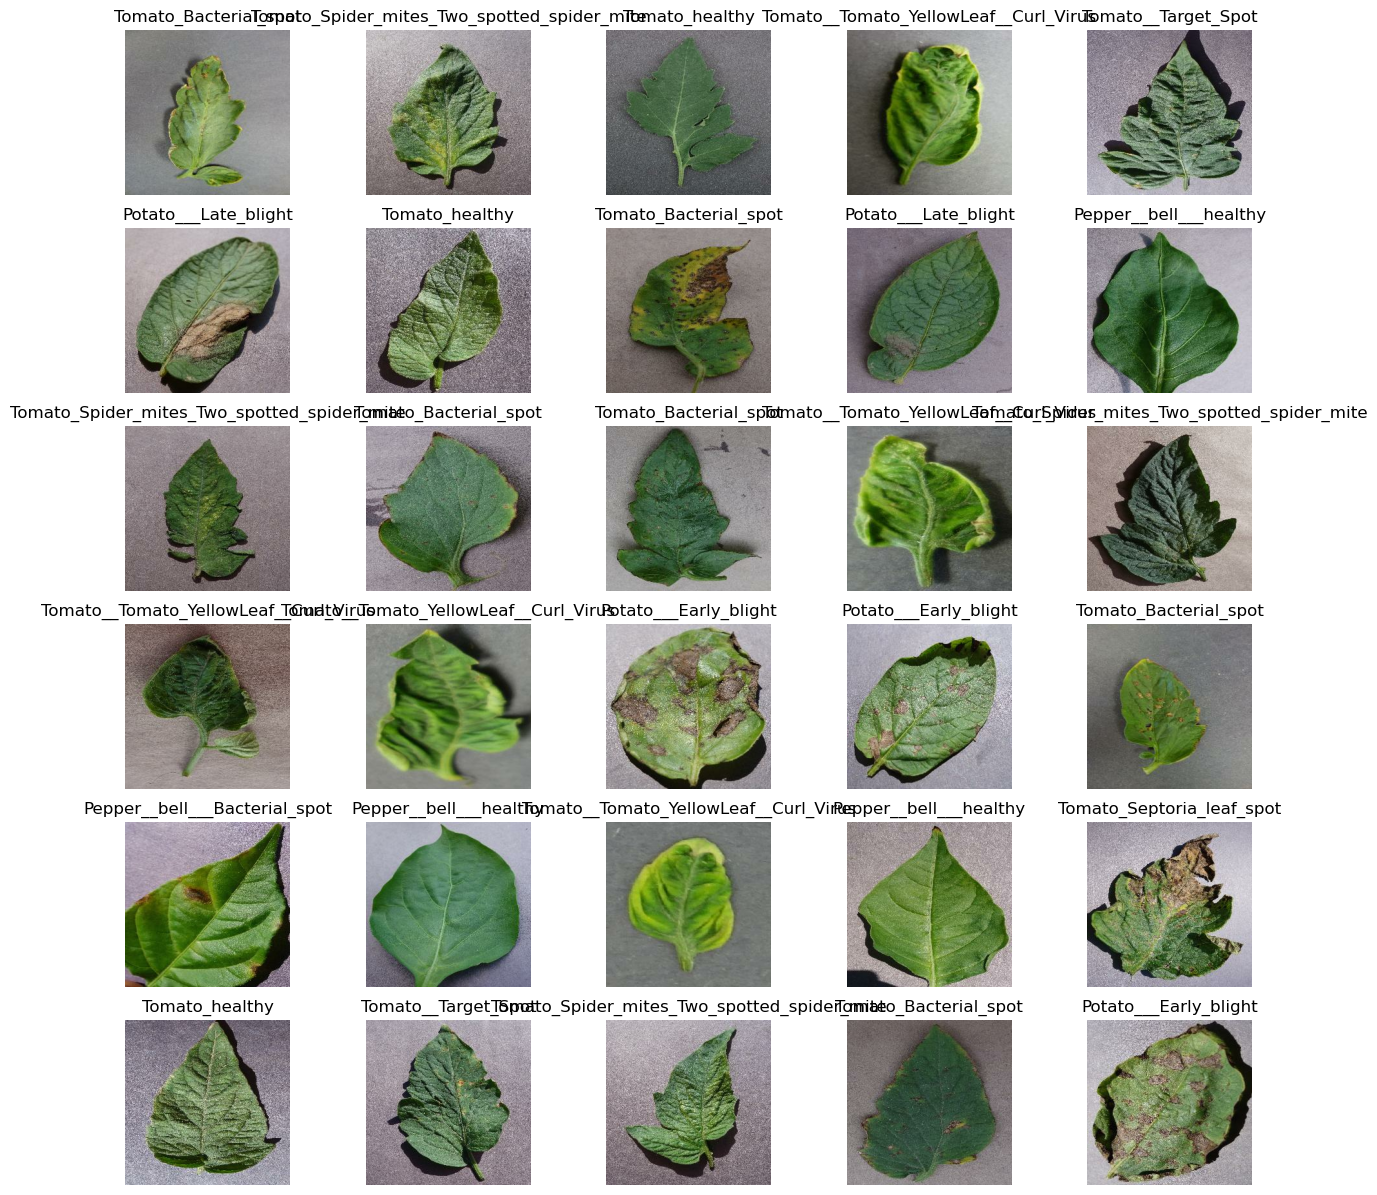

In [11]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in Dataset.take(1):
    for i in range(30):
        ax = plt.subplot(6, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
train_size = 0.8
len(Dataset)*train_size

516.0

In [13]:
train_ds = Dataset.take(516)
len(train_ds)

516

In [14]:
test_ds = Dataset.skip(516)
len(test_ds)

129

In [15]:
val_size = 0.1
len(Dataset)*val_size

64.5

In [16]:
val_ds = test_ds.take(64)
len(val_ds)

64

In [17]:
test_ds = test_ds.skip(64)
len(test_ds)

65

In [18]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partition(Dataset)

In [20]:
len(train_ds)

516

In [21]:
len(val_ds)

64

In [22]:
len(test_ds)

65

# Model Building

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),   # if any image provided is not 256X256
    layers.experimental.preprocessing.Rescaling(1.0/255)        # rescaling the images to [0,1] by dividing by 256
])

In [25]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, Channels)
n_classes = 15

model = models.Sequential([
    resize_rescale,
    data_aug,

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (32, 256, 256, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (32, 256, 256, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 128, 128, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (32, 128, 128, 32)        0         
                                                      

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (32, 256, 256, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (32, 256, 256, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 128, 128, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (32, 128, 128, 32)        0         
                                                      

In [31]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [31]:
history = model.fit(
        train_ds,
    epochs= Epochs,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/10
  2/516 [..............................] - ETA: 4:25:05 - loss: 2.7141 - accuracy: 0.0625 

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
for image_batch_batch, label_batch in test_ds.take(2):
    first_image = image_batch[5].numpy().astype('uint8')
    first_label = label_batch[5].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label : ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # Batch Creation

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize = (25,20))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence} ")

        plt.axis('off')

In [ ]:
models_version = 1
model.save(f"../models/{models_version}")

In [ ]:
# Save the model in .h5 format
model.save('my_model.h5')

print("Model saved to my_model.h5")

In [ ]:
# import shutil

# # Path to the .h5 file in Colab
# file_path = '/content/my_model.h5'

# # Path in Google Drive where you want to save the .h5 file
# drive_path = '/content/drive/My Drive/my_model.h5'

# # Copy the file from Colab to Google Drive
# shutil.copy(file_path, drive_path)

# print(f"File saved to: {drive_path}")
